In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import rasterio 
import skimage.io as skio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import slidingwindow as sw
import numpy as np
import tqdm
import shapely
import geopandas as gpd
from rasterio import features

In [ ]:
import timm
from fastai.vision.all import *
from SSLRS.xcit import XCiT
from mmseg.models.decode_heads import FPNHead
from mmseg.models.necks import FPN
class FCNNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone=XCiT(num_classes=0, in_chans=10,patch_size=8, embed_dim=384, depth=12, num_heads=8, eta=1.0, tokens_norm=True)
        self.neck=FPN(in_channels=[384, 384, 384, 384],out_channels=384,num_outs=4)
        self.decode_head =FPNHead(feature_strides=[8, 8, 8, 8],in_channels=[384, 384, 384, 384],channels=128,num_classes=11,in_index=[0, 1, 2, 3],dropout_ratio=0.1,align_corners=False)
#         self.init_weights()
    def forward(self, x):
        x =self.decode_head(self.neck(self.backbone(x)))
        return x
#     def init_weights(self):
#         state_dict=torch.load('./models/checkpoint0020.pth')['teacher']
#         state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
#         state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
        self.backbone.load_state_dict(state_dict,strict=False)

In [ ]:
model=FCNNET()
model.load_state_dict(torch.load('./models/SegnoSSL.pth'))
model=model.cuda()

In [ ]:
# sar=rasterio.open('/home/staff/xin/Downloads/sar/usa/denoise/sar.vrt')
sar=rasterio.open('./data/30UWE/30UWE.vrt')

In [ ]:
result=np.zeros((1,sar.shape[0],sar.shape[1]),dtype='uint8')
windows = sw.generate(result, sw.DimOrder.ChannelHeightWidth,512,0.2)

In [ ]:
#export
BAND_STATS = {
            'S2':{
                'mean': {
                    'B01': 340.76769064,
                    'B02': 429.9430203,
                    'B03': 614.21682446,
                    'B04': 590.23569706,
                    'B05': 950.68368468,
                    'B06': 1792.46290469,
                    'B07': 2075.46795189,
                    'B08': 2218.94553375,
                    'B8A': 2266.46036911,
                    'B09': 2246.0605464,
                    'B11': 1594.42694882,
                    'B12': 1009.32729131
                },
                'std': {
                    'B01': 554.81258967,
                    'B02': 572.41639287,
                    'B03': 582.87945694,
                    'B04': 675.88746967,
                    'B05': 729.89827633,
                    'B06': 1096.01480586,
                    'B07': 1273.45393088,
                    'B08': 1365.45589904,
                    'B8A': 1356.13789355,
                    'B09': 1302.3292881,
                    'B11': 1079.19066363,
                    'B12': 818.86747235
                }
            },
            'S1': {
                'mean': {
                    'VV': -12.619993741972035,
                    'VH': -19.29044597721542,
                    'VV/VH': 0.6525036195871579,
                },
                'std': {
                    'VV': 5.115911777546365,
                    'VH': 5.464428464912864,
                    'VV/VH': 30.75264076801808,
                },
                'min': {
                    'VV': -74.33214569091797,
                    'VH': -75.11137390136719,
                    'R': 3.21E-2
                },
                'max': {
                    'VV': 34.60696029663086,
                    'VH': 33.59768295288086,
                    'R': 1.08
                }
            }
        }
#export
bands=['B02','B03', 'B04', 'B05','B06', 'B07', 'B11', 'B08','B8A', 'B12']
means=[BAND_STATS['S2']['mean'][band]/10000 for band in bands]
stds=[BAND_STATS['S2']['std'][band]/10000 for band in bands]

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
aug_pipe = A.Compose([A.Normalize(mean=means,std=stds,max_pixel_value=1.0),
                         ToTensorV2()]                    
                    )

In [ ]:
for tt in tqdm.tqdm(windows):
    temp2=sar.read(window=Window(tt.x,tt.y,tt.w,tt.h)).copy()[:-1].transpose(1,2,0).astype('float32')/10000
    mx = np.ma.masked_invalid(temp2)
    temp2=np.nan_to_num(mx.data,0)
    temp2=aug_pipe(image=temp2)['image']
    with torch.no_grad():
        pred=model(temp2.unsqueeze(0).cuda())
    pred = F.softmax(pred, dim=1)    
    pred =F.upsample_nearest(pred,scale_factor=4)
    pred = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy().astype('uint8')
    pred=pred+1
    pred[mx.mask[:,:,0]]=0
    result[tt.indices()][0]=pred

  0%|          | 0/1242 [00:00<?, ?it/s]/home/staff/xin/.local/lib/python3.7/site-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1242/1242 [02:10<00:00,  9.49it/s]


In [ ]:
cc=['#FFFFFF','#006400','#ffbb22','#ffff4c','#f096ff','#fa0000','#b4b4b4','#f0f0f0','#0064c8','#0096a0','#00cf75','#fae6a0']


In [ ]:
from matplotlib import cm
from PIL import ImageColor
colors=[np.asanyarray(ImageColor.getcolor(c, "RGB")) for c in cc]
colors=np.asanyarray(colors).astype('uint8')

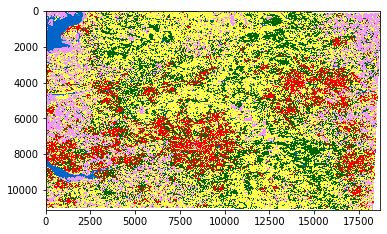

In [ ]:
plt.imshow(colors[result[0]])

In [ ]:
ll=sar.read(11)

In [ ]:
for i, blk in enumerate([10,20,30,40,50,60,70,80,90,95,100]):
    ll[ll==blk]=i

In [ ]:
ll=ll+1
ll=np.nan_to_num(ll,0)

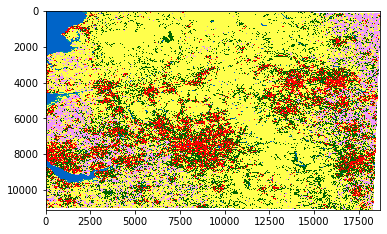

In [ ]:
plt.imshow(colors[ll.astype('uint8')])

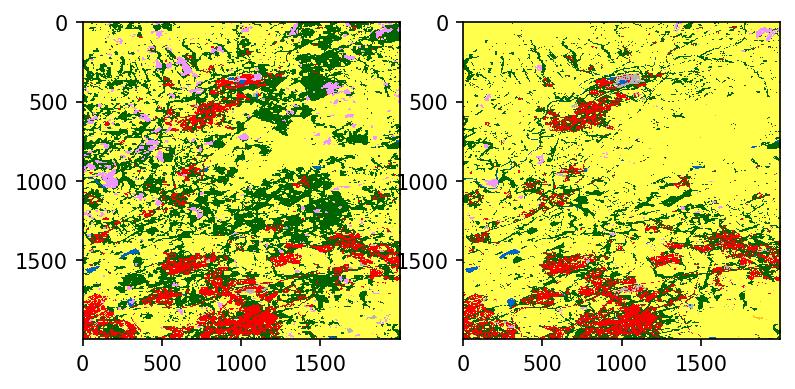

In [ ]:
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(colors[result[0][2500:4500,6000:8000]])
plt.subplot(122)
plt.imshow(colors[ll.astype('uint8')[2500:4500,6000:8000]])

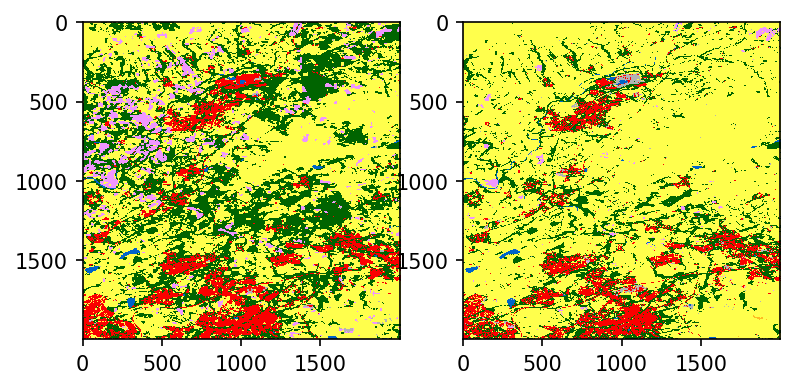

In [ ]:
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(colors[result[0][2500:4500,6000:8000]])
plt.subplot(122)
plt.imshow(colors[ll.astype('uint8')[2500:4500,6000:8000]])